# 1.  IMPORTING AND CLEANING THE DATA

In [2]:
import pandas as pd
import os
import re
import tldextract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import os, time, http.client
from termcolor import colored
import sys
import json
from pygments import highlight, lexers, formatters
import pycountry

In [2]:
#iclabcombined = pd.read_csv("combined.csv", dtype={'country' : str})

/Users/akhileshpandita/AnacondaParentFolder/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,7,10,11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dropping the columns which were meant for internal use of ICLAB team and the header columns which have come into dataset via join

In [3]:
# iclabcombined.drop(['filename', 'as_number'], axis=1, inplace= True)

# iclabcombined.drop([ 3078134,  4235577, 12411076, 18967078, 25041685, 26600938,
#             28192530, 29460039, 30795516, 32569776, 34391850, 36093972,
#             37793956, 39298313, 40934970, 42276914, 42976448, 44455181,
#             47068048, 49383978], inplace = True)

In [4]:
# iclabcombined['dns'].replace('false',False,inplace=True)
# iclabcombined['dns_all'].replace('false',False,inplace=True)
# iclabcombined['block'].replace('false',False,inplace=True)
# iclabcombined['packet_updated'].replace('false',False,inplace=True)
# iclabcombined['censored_updated'].replace('false',False,inplace=True)

# iclabcombined['dns'].replace('true',True,inplace=True)
# iclabcombined['dns_all'].replace('true',True,inplace=True)
# iclabcombined['block'].replace('true',True,inplace=True)
# iclabcombined['packet_updated'].replace('true',True,inplace=True)
# iclabcombined['censored_updated'].replace('true',True,inplace=True)

# Importing categories

In [4]:
#catDF = pd.read_fwf('type_domain_mapping.txt',header=None, names=[ "Name"], sep="")

In [5]:
#catDF = catDF.Name.apply(lambda x: pd.Series(str(x).split("|||"))).rename(columns={0:'category',1:'site'})
#catDF.head()

,category,site
0,Abortion,aborto.aaldeia.net
1,Abortion,www.abortionno.org
2,Abortion,www.aborto.com
3,Abortion,www.aborto.com.br
4,Abortion,www.clebercyto.com


In [7]:
# ADDING CATEGORY AS A PERMANENT COLUMN

# urlListAll = iclabcombined['url'].tolist()
# sitesListAll = []

# for item in urlListAll:
#     domainAll = tldextract.extract(item)[1]
#     suffixAll = tldextract.extract(item)[2]
#     sitesListAll.append(domainAll + "." + suffixAll)

In [8]:
# iclabcombined['site'] = sitesListAll
# iclabcombined = pd.merge(iclabcombined, catDF, on='site',how='left')

In [9]:
# PICKLING OUR DATA FOR FASTER ACCESS
#iclabcombined.to_pickle('iclabcombined.pkl')

In [78]:
# LOADING DATA FRAME FROM PICKLE
iclabcombined = pd.read_pickle('iclabcombined.pkl')

In [79]:
iclabcombined.shape

(50436846, 17)

#### Below query shows that every observation in this dataset has at least one method of censorship = True

In [ ]:
iclabcombined[(iclabcombined['dns']==False)&(iclabcombined['dns_all']==False) & (iclabcombined['block']==False)&(iclabcombined['packet_updated']==False)&(iclabcombined['censored_updated']==False)]

# 2. ANALYZING US BLOCKED PAGES


#### Below query basically returns all unique sites which are censored in US and from blocked we mean censored_updated = True.

In [ ]:
#function to find blocked URLs
def blockedURLs(cc):
    return (set(iclabcombined[ (iclabcombined['country']== cc)& ((iclabcombined['censored_updated']==True)) ]['url']))

In [ ]:
(blockedURLs('US'))

In [ ]:
len(blockedURLs('US'))

Strange results from above query. Sites like http://alibaba.com, http://docs.google.com, http://duckduckgo.com, http://bbc.com/, http://google.jp or http://google.fr or even http://americanexpress.com/ which are perfectly accessible in the US are shown as blocked

As an example just looking at the status of http://americanexpress.com/ throughout the study

In [ ]:
iclabcombined[(iclabcombined['url']=='http://americanexpress.com/') & (iclabcombined['country']=='US') & (iclabcombined['censored_updated']== True) ]

We find that only once during the testing i.e. in June 2017, americanexpress.com was blocked and that was due to a packet injection.
As per https://www.pico.net/kb/what-is-a-tcp-reset-rst this happens because the packet arrives on a TCP connection that was previously established, but the local application already closed its socket or exited and the OS closed the socket. Other circumstances are possible, but are unlikely outside of malicious behavior such as attempts to hijack a TCP connection. HENCE WONT BE WISE TO CONSIDER THIS AS BLOCKED

The below query produces 167 urls, these are the URLs for which the ICLab team believes the packets might have been injected i.e. becuase there was a response after RST or FIN or maybe because of ICMP admin prohibited i.e. they determined there's a firewall that blocks a connection. Removing these from our data as these are cases of PROBABLE CENSORSHIP and not ACTUAL censorship

In [ ]:
( set(iclabcombined[ (iclabcombined['country']=='US')  & ((iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['packet_updated']== True))]['url']))

Even urls for which a 4xx or 5xx result was returned are accessible and some of them are URLS commonly accessed in US

In [ ]:
set(iclabcombined
    [ (iclabcombined['country']=='US') 
                   & 
     (
         (iclabcombined['http_status']== 403.0) | (iclabcombined['http_status']== 404.0) | (iclabcombined['http_status']== 504.0)
     )
     &
     (   
                       (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False)
                       & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) 
                       & (iclabcombined['packet_updated']== True)
                   )]
     ['url'])

### Removing the FALSE POSITIVIES from our main dataset iclabcombined

In [11]:
httpError = np.arange(400,600,1,dtype=float)

We define False Positive's here as the sites which return a http 200 and only show packet_updated = True

In below query, I eliminate the countries where the result of HTTP was not a 400/500 errorand the only mechanism of censorship was that the packet_updated = True i.e. all these are probable censorships i.e. FALSE POSITIVIES

In [12]:
falsePositIndex = iclabcombined[
    (~iclabcombined.http_status.isin(httpError))  
                   & (   (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['packet_updated']== True)
                     )] [['country','url','http_status']].index.tolist()

In [13]:
print("We have " + str(len(falsePositIndex)) + " probable censoriships which could be false positives")

We have 38645 probable censoriships which could be false positives


In [14]:
iclabcombined.drop(falsePositIndex,inplace=True)

### COULD FALSE POSITIVES BE ACTUALLY USEFUL

Lets look at NL and KR

In [ ]:
iclabcombined [ (iclabcombined['censored_updated']==True) & (iclabcombined['packet_updated']==True) & (iclabcombined['dns']==False) & (iclabcombined['dns_all']==False) & (iclabcombined['block']==False) & (iclabcombined['country']=='KR') & (iclabcombined['http_status']==403)]['url'].unique()

In [ ]:
iclabcombined [ (iclabcombined['censored_updated']==True) & (iclabcombined['packet_updated']==True) & (iclabcombined['dns']==False) & (iclabcombined['dns_all']==False) & (iclabcombined['block']==False) & (iclabcombined['country']=='NL') & (iclabcombined['http_status']==403)]['url'].unique()

### Now having a look at FALSE NEGATIVES

We define false negatives as websites which are showing censored_updated = False here but upon testing actually are inaccessible

In [ ]:
set(iclabcombined[(iclabcombined['country']=='US')&(iclabcombined['censored_updated']==False) & (iclabcombined.http_status.isin([403.0]))]['url'])

In total as seen below we have 3389 websites which show up as not censored in US but the corresponding HTTP results are error codes, manual testing of these websites show that they are accessible, its not possible to actually determine the status of all false negatives. Based on our testing and seeing that they are not marked as blocked eventually and also because we believe that false negatives are not too critical to our project  $hence we wont drop them from the data set$

 ### NOW from this data looking at the sites that are shown as censored in US. THESE SITES HAVE CENSORED = TRUE AND RETURN A HTTP ERROR

In [ ]:
set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_status.isin(httpError) & ( (iclabcombined['dns_all']== True) | (iclabcombined['block']== True)|(iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True)))]['url'])

In [ ]:
# SITES SHOWING HTTP status reason as block in US but still accessible
set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_reason.str.contains('block'))]['url'])

Overall all the above results show a very dirty data, we basically removed the root urls of all the sites that show 404 in US and then checked how many of them are accesible. There are no patterns while some are showing as blocked on testing others are not. BELOW WE REMOVE THESE FALSE POSITIVIES FROM THE US

In [15]:
USFPlist = (iclabcombined [(iclabcombined['country']=='US') & ((iclabcombined['dns'] == True)|(iclabcombined['dns_all'] == True)|(iclabcombined['block'] == True)|(iclabcombined['censored_updated'] == True) | (iclabcombined['packet_updated'] == True))]['site']).unique().tolist()

### So basically below we have a list of 308 websites which are shown as blocked in US in some way but we consider them to be false positives

In [15]:
display(len(USFPlist))
display(len(iclabcombined[iclabcombined['site'].isin(USFPlist)]))

308

### We see there are as many as 8921198  observations which are tested for sites that were estimated to be  blocked in US . Since as part of our experiment we consider them to be false positives, we will drop these rows

In [17]:
USFPIndex = iclabcombined[iclabcombined['site'].isin(USFPlist)].index

In [18]:
iclabCLEAN = iclabcombined.drop(USFPIndex)

In [19]:
# PICKLING OUR DATA FOR FASTER ACCESS
iclabCLEAN.to_pickle('iclabCLEAN.pkl')

In [3]:
# LOADING DATA FRAME FROM PICKLE
iclabCLEAN = pd.read_pickle('iclabCLEAN.pkl')

In [5]:
#display(iclabcombined.shape)
display(iclabCLEAN.shape)

(41477003, 17)

$******************************************************************$

# 3.  EXPERIMENT 1

### Looking at the exact webpages blocked

In [ ]:
blockpageTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
len(blockpageTR)

In [ ]:
blockpageRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
len(blockpageRU)

In [ ]:
RUblockpageTR = blockpageTR.intersection(blockpageRU)
RUblockpageTR

# EXPERIMENT 2

In [ ]:
blockIN = set(iclabCLEAN[(iclabCLEAN['country']=='IN') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockIN)

In [ ]:
blockCN = set(iclabCLEAN[(iclabCLEAN['country']=='CN') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockCN)

In [ ]:
blockVN = set(iclabCLEAN[(iclabCLEAN['country']=='VN') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockVN)

In [ ]:
blockRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True)| (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True))]['site'])
len(blockRU)

In [ ]:
blockTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['site'])
len(blockTR)

In [ ]:
blockNL = set(iclabCLEAN[(iclabCLEAN['country']=='NL') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockNL)

In [ ]:
blockAU = set(iclabCLEAN[(iclabCLEAN['country']=='AU') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockAU)

In [ ]:
blockNZ = set(iclabCLEAN[(iclabCLEAN['country']=='NZ') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockNZ)

In [ ]:
AU_NZ = blockNZ.intersection(blockAU)
len(AU_NZ)

In [ ]:
blockMX = set(iclabCLEAN[(iclabCLEAN['country']=='MX') & ((iclabCLEAN['censored_updated']==True))]['site'])
len(blockMX)

In [ ]:
IN_RU = blockIN.intersection(blockRU)
(IN_RU)

### Intersections as per EXPERIMENT 2

In [ ]:
RU_TR = blockRU.intersection(blockTR)

In [ ]:
BR_MX = blockMX.intersection(blockBR)

In [ ]:
NL_TR = blockNL.intersection(blockTR)

### As part of Experiment 2 : 
### (a) A look at censored FB Pages in India

Looking at worldwide distribution of FB blocking

In [ ]:
iclabCLEAN[iclabCLEAN['url'].str.contains('facebook')].groupby('country').count()

Looking at FB pages censored in India

In [ ]:
fbIndBlock = set (iclabcombined [ ( (iclabcombined['block']== True) | (iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True) ) & (iclabcombined['url'].str.contains('facebook')) & (iclabcombined['country']=='IN') ]['url'])
fbIndBlock

### (b) A look into religious censorship in the world

In [ ]:
iclabCLEAN[ (iclabCLEAN['category'].isin(['Global Religion','Alternative Beliefs'])) & ( (iclabCLEAN['block']== True) | (iclabCLEAN['censored_updated'] == True) ) ].groupby(['country', 'site']).first()

# 4 EXPERIMENT 3 : 

In [6]:
def Category_contributions(cc):
    catDataCC = iclabCLEAN[(iclabCLEAN['country']==cc) & (iclabCLEAN['censored_updated']==True)]
    catDataCC= catDataCC.drop(['server_t', 'censored_updated','site','dns_all','packet_reason','url','dns','dns_reason','dns_reason_all','schedule_name','http_status','block','body_len','http_reason','packet_updated'], axis=1)
    catDataCC = catDataCC.groupby('category').count()
    catDataCC['%Cat'] = (catDataCC['country']*100)/(catDataCC['country'].sum())
    catDataCC= catDataCC.reset_index()
    catDataCC = (catDataCC[catDataCC['%Cat'] >= 1]).drop('country',axis=1)
    catDataCC= catDataCC.rename(columns={'country':'Number of sites in' + str(cc),'%Cat':cc})
    return catDataCC

In [322]:
INplot = Category_contributions('IN')
display(INplot)
TRplot =Category_contributions('TR')
RUplot = Category_contributions('RU')
KRplot= Category_contributions('KR')
USplot = Category_contributions('US')
CNplot = Category_contributions('CN')
CAplot  = Category_contributions('CA')
ZAplot  = Category_contributions('ZA')

,category,IN
0,Advertising,1.807921
2,Arts and Culture,1.113719
7,Domain Parking,1.618139
10,Entertainment,21.959746
11,File Sharing and Storage,7.341557
15,General Organizations,1.393398
16,Global Religion,2.282375
20,Illegal or Unethical,4.145233
21,Information Technology,4.459871
26,News and Media,11.561704


#### Plotting the graph below:

In [323]:
graphcompare1 = pd.merge(INplot,TRplot, on='category', how='outer')
graphcompare2 = pd.merge(graphcompare1,KRplot, on='category', how='outer')
graphcompare3 = pd.merge(graphcompare2,RUplot, on='category', how='outer')
graphcompare4 = pd.merge(graphcompare3,USplot, on='category', how='outer')
graphcompare5 = pd.merge(graphcompare4,CNplot, on='category', how='outer')

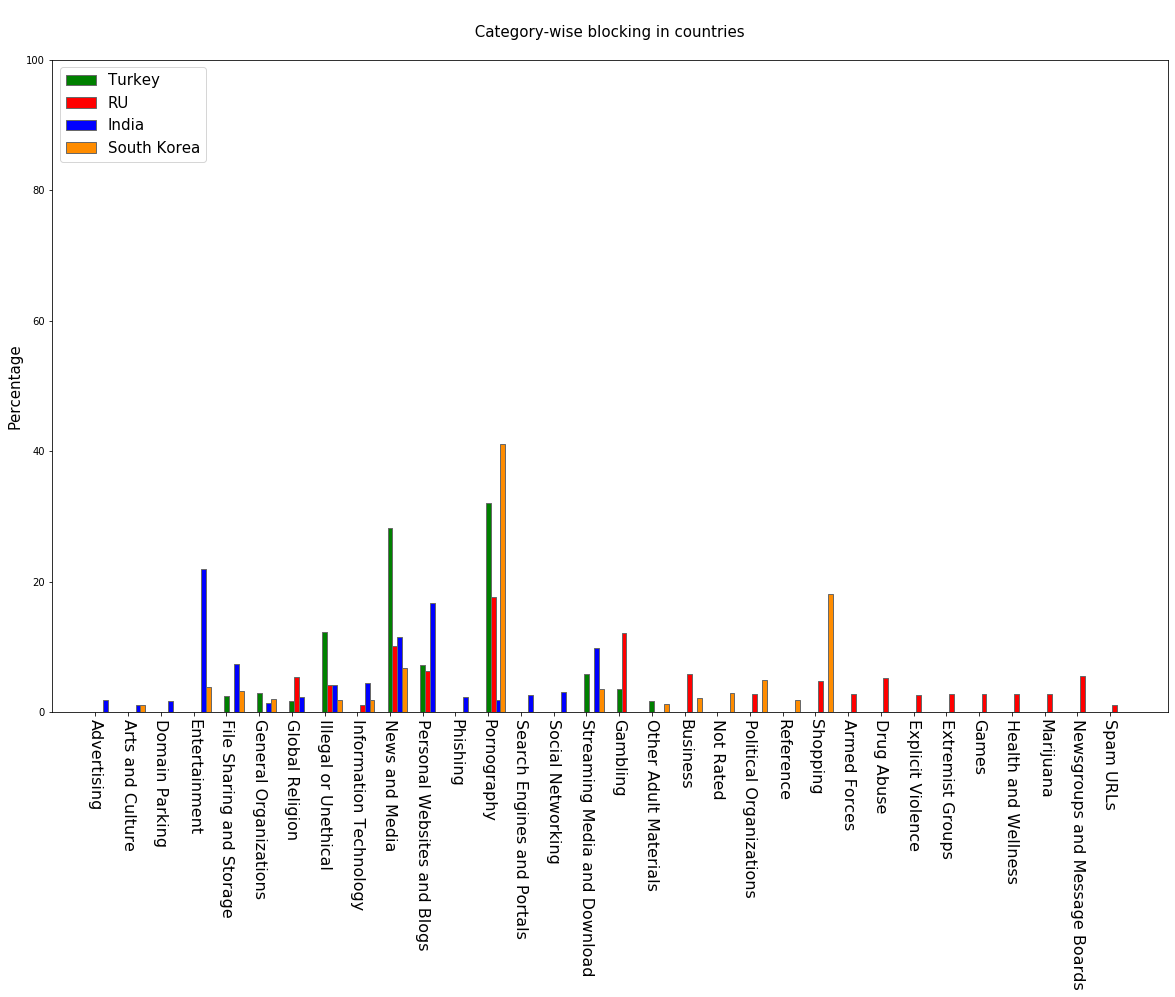

In [324]:
# set width of bar
barWidth = 0.15
 
# set height of bar
TR = graphcompare3['TR']
RU = graphcompare3['RU']
IN = graphcompare3['IN']
KR = graphcompare3['KR']
 
# Set position of bar on X axis
r1 = np.arange(len(TR))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.figure(figsize = (20,12))
plt.bar(r1, TR, color='green', width=barWidth, edgecolor='dimgrey', label='Turkey')
plt.bar(r2, RU, color='red', width=barWidth ,  edgecolor='dimgrey',label='RU')
plt.bar(r3, IN, color='blue', width=barWidth,  edgecolor='dimgrey',label='India')
plt.bar(r4, KR, color='darkorange', width=barWidth,  edgecolor= 'dimgrey',label='South Korea') 

# Add xticks on the middle of the group bars
plt.ylabel("Percentage", size=15)
plt.ylim(0,100)
plt.xticks([r for r in range(len(TR))], graphcompare3['category'].tolist() ,rotation=-90, size=16)

# Create legend & Show graphic
plt.legend(loc = 'upper left', fontsize = 15)
plt.title("\n Category-wise blocking in countries \n", size = 15)
plt.show()

# COMPUTING THE SIMILARITY METRICS

#### A few sample metrics

In [325]:
graphcompare5.fillna(0,inplace=True)

In [326]:
KRvals = graphcompare5['KR']
RUvals = graphcompare5['RU']
INvals = graphcompare5['IN']
TRvals = graphcompare5['TR']

In [ ]:
KRsimilarityRU = (1 - spatial.distance.cosine(KRvals, RUvals))*100
KRsimilarityRU

In [ ]:
INsimilarityTR = (1 - spatial.distance.cosine(INvals, TRvals))*100
INsimilarityTR

In [ ]:
INsimilarityKR = (1 - spatial.distance.cosine(INvals, KRvals))*100
INsimilarityKR

In [ ]:
INsimilarityRU = (1 - spatial.distance.cosine(INvals, RUvals))*100
INsimilarityRU

In [ ]:
KRsimilarityTR = (1 - spatial.distance.cosine(KRvals, TRvals))*100
KRsimilarityTR

In [327]:
RUsimilarityTR = (1 - spatial.distance.cosine(RUvals, TRvals))*100
RUsimilarityTR

76.46612476712447

# NOW
## SIMILARITY METRIC DATAFRAME FOR ALL COUNTRIES

In [7]:
allCountries = set(iclabCLEAN['country'])

In [33]:
simMetricDFIndex = (iclabCLEAN['category'].dropna().unique())
simMetricDF = pd.DataFrame(index = simMetricDFIndex, columns=None)
simMetricDF['base']= pd.Series(np.zeros(len(simMetricDFIndex)))
simMetricDF= simMetricDF.reset_index().rename(columns={'index':'category'})

In [34]:
for country in allCountries:
    simMetricDF = pd.merge(simMetricDF,Category_contributions(country), on= 'category', how='outer')

simMetricDF = simMetricDF.drop(['base'],axis=1)
simMetricDF = simMetricDF.set_index('category')

#REPLACING NaN's with 0
simMetricDF = simMetricDF.fillna(0)

In [35]:
display(simMetricDF.loc[:,['US']].head())
display(simMetricDF[simMetricDF['US']!=0])

,US
category,
File Sharing and Storage,0.0
Reference,0.0
Information Technology,0.0
Instant Messaging,0.0
News and Media,0.0


,CR,PE,AT,KR,IS,AU,JP,ES,BZ,NL,...,CA,HK,US,LU,PT,LT,LI,TR,NO,RU
category,,,,,,,,,,,,,,,,,,,,,


In [36]:
simCols=[]
for i in range(len(simMetricDF.columns)):
    simCols.append(simMetricDF.columns[i])

In [37]:
from itertools import combinations
pairs = [comb for comb in combinations(simCols, 2)]

In [38]:
simVal = []
for item in pairs:
    simVal.append((1 - spatial.distance.cosine(simMetricDF[item[0]], simMetricDF[item[1]]))*100)

In [39]:
simMetricVals = pd.DataFrame(index=pairs, columns = None )
simMetricVals['similarity'] = simVal
simMetricVals= simMetricVals.reset_index().rename(columns={'index':'pair'})
simMetricVals[['country_code_alpha2_A', 'country_code_alpha2_B']] = pd.DataFrame(simMetricVals['pair'].tolist(), index=simMetricVals.index)
# Reordering columns

tempCol = simMetricVals['similarity']
simMetricVals = simMetricVals.drop(labels=['similarity'], axis=1)
simMetricVals.insert(3, 'similarity', tempCol)
simMetricVals=simMetricVals.drop('pair',axis=1)
simMetricVals.head()

,country_code_alpha2_A,country_code_alpha2_B,similarity
0,CR,PE,NaN
1,CR,AT,NaN
2,CR,KR,NaN
3,CR,IS,NaN
4,CR,AU,NaN


In [77]:
simMetricVals[simMetricVals['country_code_alpha2_A']=='IRN']

,country_code_alpha2_A,country_code_alpha2_B,similarity


# REPLACING THE SIMILARITY = NAN WITH ZERO
# MUST DOUBLE CHECK

In [64]:
simMetricVals.fillna(0,inplace=True)

In [65]:
simMetricVals.head()

,country_code_alpha2_A,country_code_alpha2_B,similarity
0,CR,PE,0.0
1,CR,AT,0.0
2,CR,KR,0.0
3,CR,IS,0.0
4,CR,AU,0.0


## ==>> worldMapDemo is the similarity metric data frame without the NaN values
    NaN values arise when both the countries have 0 for a particular category and as a result the spatial cosine formula returns an undefined NaN 

In [66]:
worldMapDemoDF = simMetricVals[~(simMetricVals.similarity.isin(['NaN']))]
worldMapDemoDF.head()

,country_code_alpha2_A,country_code_alpha2_B,similarity
0,CR,PE,0.0
1,CR,AT,0.0
2,CR,KR,0.0
3,CR,IS,0.0
4,CR,AU,0.0


In [68]:
# def countryCodeConversion()

inputCountriesA = worldMapDemoDF['country_code_alpha2_A']
inputCountriesB = worldMapDemoDF['country_code_alpha2_B']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


alpha3codesA = [countries.get(country, 'Unknown code') for country in inputCountriesA]
alpha3codesB = [countries.get(country, 'Unknown code') for country in inputCountriesB]

In [69]:
worldMapDemoDF['country_code_alpha2_A'] = alpha3codesA
worldMapDemoDF['country_code_alpha2_B'] = alpha3codesB
worldMapDemoDF.head()

,country_code_alpha2_A,country_code_alpha2_B,similarity
0,CRI,PER,0.0
1,CRI,AUT,0.0
2,CRI,KOR,0.0
3,CRI,ISL,0.0
4,CRI,AUS,0.0


In [76]:
worldMapDemoDF[worldMapDemoDF['country_code_alpha2_A']=='SYR']

,country_code_alpha2_A,country_code_alpha2_B,similarity


### CONVERTING THIS DATA FRAME INTO JSON

In [70]:
worldDictList = [{i:{l:{"sim":(n)} 
       for l,n in zip(g['country_code_alpha2_B'], g['similarity'])}} 
 for i,g in worldMapDemoDF.groupby('country_code_alpha2_A')] 

In [71]:
worldDictList

[{'AND': {'CHL': {'sim': 0.0},
   'FRA': {'sim': 0.0},
   'HUN': {'sim': 0.0},
   'IND': {'sim': 0.0},
   'ZAF': {'sim': 0.0},
   'BEL': {'sim': 0.0},
   'DZA': {'sim': 0.0},
   'BGR': {'sim': 0.0},
   'BRA': {'sim': 0.0},
   'ROU': {'sim': 0.0},
   'GRC': {'sim': 0.0},
   'MDA': {'sim': 0.0},
   'MEX': {'sim': 0.0},
   'KEN': {'sim': 0.0},
   'SRB': {'sim': 0.0},
   'IDN': {'sim': 0.0},
   'SVK': {'sim': 0.0},
   'MYS': {'sim': 0.0},
   'CZE': {'sim': 0.0},
   'ISR': {'sim': 0.0},
   'VNM': {'sim': 0.0},
   'POL': {'sim': 0.0},
   'NZL': {'sim': 0.0},
   'CAN': {'sim': 0.0},
   'HKG': {'sim': 0.0},
   'USA': {'sim': 0.0},
   'LUX': {'sim': 0.0},
   'PRT': {'sim': 0.0},
   'LTU': {'sim': 0.0},
   'LIE': {'sim': 0.0},
   'TUR': {'sim': 0.0},
   'NOR': {'sim': 0.0},
   'RUS': {'sim': 0.0}}},
 {'AUS': {'JPN': {'sim': 40.18652332246864},
   'ESP': {'sim': 0.0},
   'BLZ': {'sim': 0.0},
   'NLD': {'sim': 54.62065693236005},
   'SGP': {'sim': 34.94816226644152},
   'DNK': {'sim': 0.0},
   'SA

In [72]:
finalStr = "{"

for item in worldDictList:
    i = (json.dumps(item))
    i = i[1:-1]
    finalStr = finalStr + i
    finalStr = finalStr + ","

finalStr = finalStr[0: -1]
finalStr = finalStr + "}"
jsonFormatted = json.dumps(json.loads(finalStr))
#jsonBeautified = highlight(str(jsonFormatted), lexers.JsonLexer(), formatters.TerminalFormatter())
print(jsonFormatted)

{"AND": {"CHL": {"sim": 0.0}, "FRA": {"sim": 0.0}, "HUN": {"sim": 0.0}, "IND": {"sim": 0.0}, "ZAF": {"sim": 0.0}, "BEL": {"sim": 0.0}, "DZA": {"sim": 0.0}, "BGR": {"sim": 0.0}, "BRA": {"sim": 0.0}, "ROU": {"sim": 0.0}, "GRC": {"sim": 0.0}, "MDA": {"sim": 0.0}, "MEX": {"sim": 0.0}, "KEN": {"sim": 0.0}, "SRB": {"sim": 0.0}, "IDN": {"sim": 0.0}, "SVK": {"sim": 0.0}, "MYS": {"sim": 0.0}, "CZE": {"sim": 0.0}, "ISR": {"sim": 0.0}, "VNM": {"sim": 0.0}, "POL": {"sim": 0.0}, "NZL": {"sim": 0.0}, "CAN": {"sim": 0.0}, "HKG": {"sim": 0.0}, "USA": {"sim": 0.0}, "LUX": {"sim": 0.0}, "PRT": {"sim": 0.0}, "LTU": {"sim": 0.0}, "LIE": {"sim": 0.0}, "TUR": {"sim": 0.0}, "NOR": {"sim": 0.0}, "RUS": {"sim": 0.0}}, "AUS": {"JPN": {"sim": 40.18652332246864}, "ESP": {"sim": 0.0}, "BLZ": {"sim": 0.0}, "NLD": {"sim": 54.62065693236005}, "SGP": {"sim": 34.94816226644152}, "DNK": {"sim": 0.0}, "SAU": {"sim": 27.35976369033739}, "VEN": {"sim": 0.0}, "FIN": {"sim": 0.0}, "SWE": {"sim": 27.054726107528747}, "COL": {

### Saving JSON as file WorldMapInput

In [73]:
with open('FINALVIZ.json', 'w') as outfile:
    json.dump(jsonFormatted, outfile)

## Further Analysis

In [ ]:
MidEast = ['IR','IQ','SY']

In [ ]:
#iclabcombined[(iclabcombined['country']=='IQ') or (iclabcombined['country']=='IQ')]

In [ ]:
iclabcombined[iclabcombined.country.isin(MidEast)]